In [38]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/my_lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

## Surveys and models
We generate lightcones with $\Omega_{\rm field} = 400$deg$^2$ but sensitivities corresponding to 3 main experiments: COMAP, EXCLAIM, and HETDEX.

Line | Redshifts | $\sigma_N$ ($\mu$K) | $\theta_{\rm FWHM}$ (arcmin)|
 --- |    ---    |          ---        |            ---              |
 CO  | 2.4-3.4   |           5         |         4.5 arcmin          |

In [4]:
def LC_params(line):
    if line=='CO':
        nu_CO=115.271*u.GHz
        z_min = 2.4
        z_max = 3.4
        model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                          lines=dict(CO=True),
                          models=dict(CO=dict(model_name='CO_Li16',
                                              model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=1,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1)
        obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                        RAObs_min=-10*u.deg,RAObs_max=10*u.deg,
                        DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                        RA_min=-10*u.deg,RA_max=10*u.deg,
                        DEC_min=-10*u.deg,DEC_max=10*u.deg,
                        nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                        dnu=31.25*u.MHz,
                        Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                        Nfeeds=19*2,
                        beam_FWHM=4.5*u.arcmin,
                        tobs=1000*u.hr,
                        linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                        do_smooth=True)
        obs_params.update(model_params)
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        zmin_CII = 3.4
        zmax_CII = 3.9
        CII=make_measurements(dict(halo_lightcone_dir='/home/gsatopolito/JHU/Research/SQLC files/',
                                  lines=dict(CII=True),
                                   target_line = 'CII',
                                  models=dict(CII=dict(model_name='CII_Silva15',model_pars={'aLCII':1.,'bLCII':6.9647, 'sigma_L':0.3})),
                                   do_external_SFR = False, external_SFR = '',
                                  SFR_pars=dict(),
                                  supersample=1,
                                  Nmu=10,
                                  dk=0.02*u.Mpc**-1,
                                  zmin = zmin_CII-0.03, zmax = zmax_CII+0.03,
                                  RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                                  DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                                  RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                                  DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                                  nuObs_max=nu_CII/(1+zmin_CII), nuObs_min=nu_CII/(1+zmax_CII),
                                  beam_FWHM=30*u.arcsec,
                                  dnu=4.1*u.GHz,
                                  Tsys=(8/400)*61500*((np.pi/(4.*np.log(2))*(30*u.arcsec)**2).to(u.sr)).value*u.Jy*u.s**0.5, 
                                  Nfeeds=2,
                                  tobs=4000*u.hr,
                                  linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                                  do_smooth=True))
    return obs_params

In [5]:
LC_CO=make_measurements(LC_params('CO'))

In [6]:
CO_map=np.asarray(LC_CO.obs_3d_map)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

../../preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


### Luminosity function

In [7]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (LC_CO.nuObs_line_halo['CO'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO'] <= LC_CO.nuObs_max)&inds_sky
M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(LC_CO.Msunh).value

logMcat=np.log10(M_in_survey)
LCO = LC_CO.halos_in_survey['CO']['Lhalo'].value
logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)

meanLCO=[]
for i in range(len(logM)-1):
    inds = (logMcat>=logM[i])&(logMcat<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin))     

meanLCO = np.asarray(meanLCO)

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

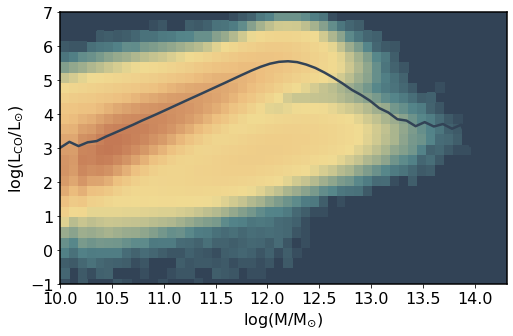

In [50]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

ax.hist2d(logMcat[LCO>0], np.log10(LCO[LCO>0]), bins=[50, 40], norm=mpl.colors.LogNorm(), cmap=cmap, density=True)
ax.plot(logM[:-1], np.log10(meanLCO), color=grey)
ax.set_facecolor(grey)
ax.set_ylim(-1, 7)
#plt.colorbar()
plt.xlabel(r'$\log$(M/M$_{\odot}$)')
plt.ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
plt.show()